First we grab the adjusted close price from the 6 stocks from yahoo using yfinance, formattting it into a pandas data frame. And then we take the adjusted close price from each ticker.

In [1]:
#installing dependencies
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
tickers = ['XLU','TD.TO','AAPL','VTI','AON','AMD']

# Define the start date
start_date = '2017-05-01'

# Initialize an empty DataFrame to store adjusted close prices
adjusted_close_prices = pd.DataFrame()

# Fetch adjusted close prices for each ticker
for ticker in tickers:
    # Fetch historical data from Yahoo Finance
    data = yf.download(ticker, start=start_date)
    daily_close_prices = data['Adj Close']
    adjusted_close_prices[ticker] = daily_close_prices

adjusted_close_prices

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,XLU,TD.TO,AAPL,VTI,AON,AMD
Date,,,,,,
2017-05-01,41.325352,49.295231,34.207829,109.636520,113.017609,13.620000
2017-05-02,41.373608,48.858040,34.424850,109.636520,112.669975,10.320000
2017-05-03,41.228855,48.681622,34.319851,109.368973,113.064575,10.390000
2017-05-04,41.373608,48.543568,34.196159,109.449242,113.872589,10.100000
2017-05-05,41.598770,49.157166,34.763252,109.993271,114.877884,10.190000
...,...,...,...,...,...,...
2024-03-05,62.580002,80.510002,170.119995,251.949997,315.200012,205.130005
2024-03-06,63.180000,81.669998,169.119995,253.440002,317.089996,210.630005
2024-03-07,63.590000,81.779999,169.000000,255.910004,316.690002,211.380005


In [3]:
table = adjusted_close_prices

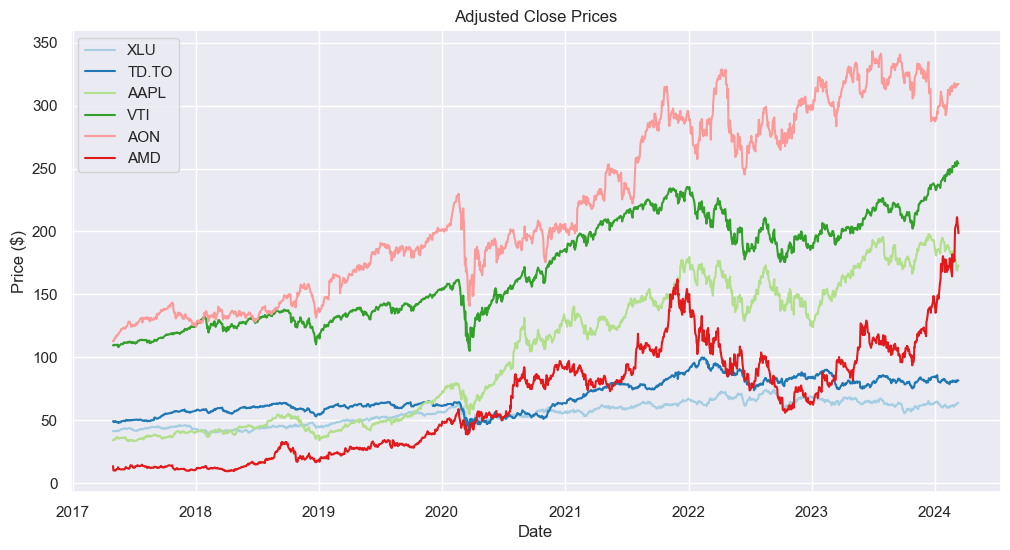

In [4]:
# Use Seaborn to plot the adjusted close prices
sns.set(style="darkgrid")
sns.set_palette("Paired")
plt.figure(figsize=(12, 6))

# Plot the adjusted close prices
for ticker in tickers:
    sns.lineplot(data=table[ticker], label=ticker)

plt.title('Adjusted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

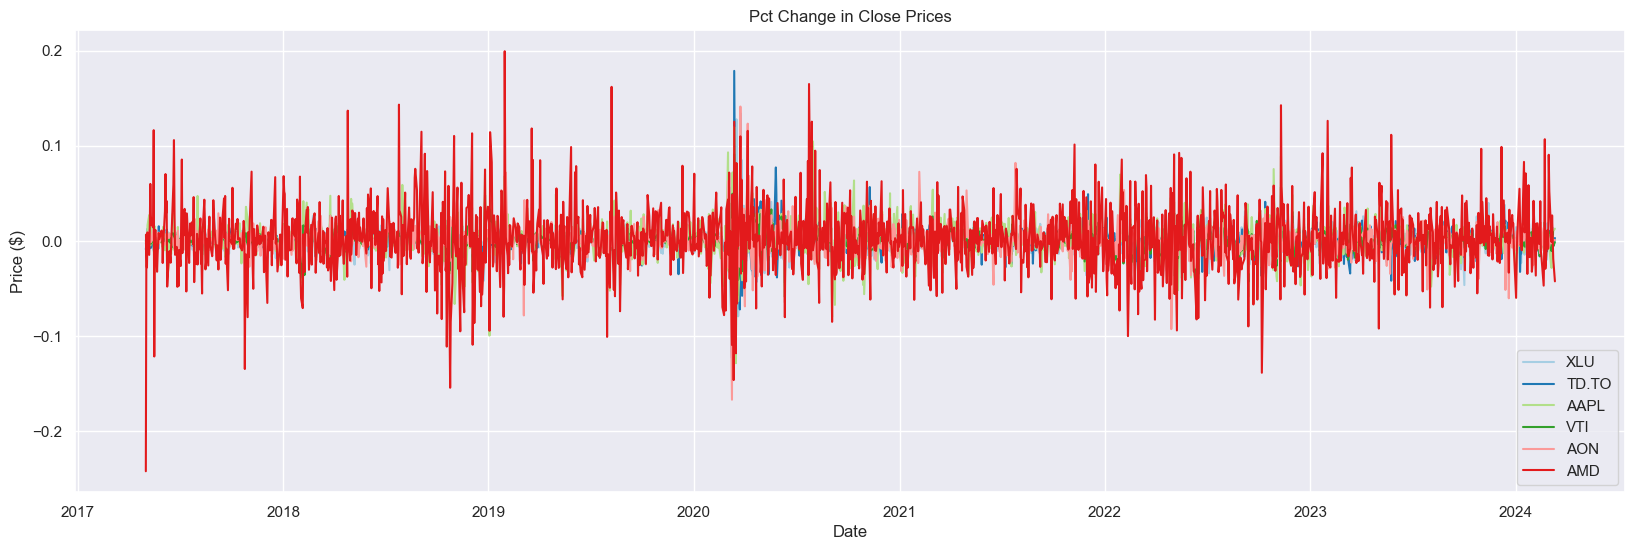

In [5]:
returns = table.pct_change()
plt.figure(figsize=(20, 6))
for ticker in tickers:
    sns.lineplot(data=returns[ticker], label=ticker)

plt.title('Pct Change in Close Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [6]:
returns = table.pct_change()
mean_returns = returns.mean().values
cov_matrix = returns.cov().values
num_portfolios = 100000
risk_free_rate = 0.02

In [7]:
def portfolio_annualised_performance(weights,mean_returns,cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))*np.sqrt(252)
    return std,returns

In [8]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [9]:

def display_sim_ef(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights_record = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp,rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights_record[max_sharpe_idx], index=table.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min,rp_min = results[0,min_vol_idx],results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights_record[min_vol_idx], index=table.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print('Max Sharpe Ratio Portfolio Allocation\n')
    print('Annualised Return:', round(rp, 2))
    print('Annualised Volatility:', round(sdp, 2))
    print(max_sharpe_allocation)
    print("-----------------------------------------------")
    print('Minimum Volatility Portfolio Allocation\n')
    print('Annualised Return:', round(rp_min, 2))
    print('Annualised Volatility:', round(sdp_min, 2))
    print(min_vol_allocation)
        
        
    plt.figure(figsize=(8,6))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='magma',marker='o',s=10,alpha=0.3)
    plt.colorbar()
    plt.title('Portfolio Optimization based on the Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.scatter(sdp,rp,marker = '*',color ='r',label = 'Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker = '*',color ='g',label = 'Minimum volatility')
    plt.legend(labelspacing = 0.8)

Max Sharpe Ratio Portfolio Allocation

Annualised Return: 0.34
Annualised Volatility: 0.3
             XLU  TD.TO   AAPL   VTI    AON    AMD
allocation  1.59   1.42  31.72  1.22  29.46  34.59
-----------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.11
Annualised Volatility: 0.17
              XLU  TD.TO  AAPL    VTI   AON   AMD
allocation  34.41  35.75   1.8  17.84  9.58  0.61


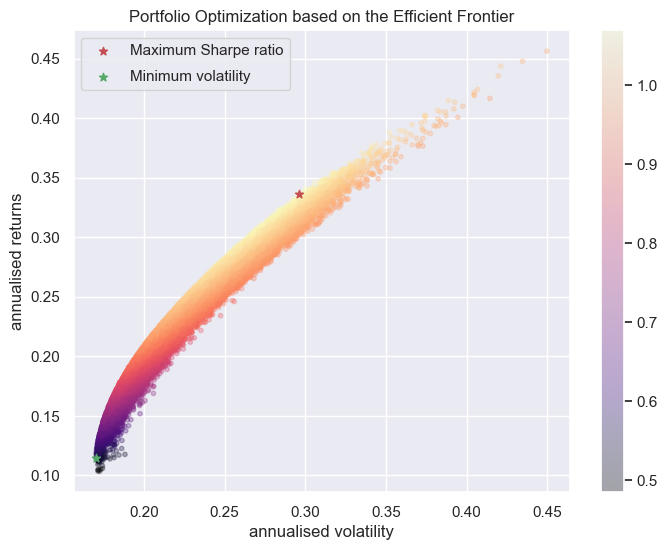

In [10]:
display_sim_ef(mean_returns,cov_matrix,num_portfolios,risk_free_rate)

In [16]:
allocations = {
    'XLU': 1.59/100,
    'TD.TO': 1.42/100,
    'AAPL': 31.72/100,
    'VTI': 1.22/100,
    'AON': 29.46/100,
    'AMD': 34.59/100
}

In [17]:
prices = adjusted_close_prices.iloc[-1].to_dict()
total_amount = 152170.10

prices

{'XLU': 63.94499969482422,
 'TD.TO': 81.62000274658203,
 'AAPL': 172.92990112304688,
 'VTI': 254.08999633789062,
 'AON': 317.07501220703125,
 'AMD': 198.57000732421875}

In [18]:
amount_allocated = {stock: allocations[stock] * total_amount for stock in allocations}
shares_to_purchase = {stock: amount_allocated[stock] / prices[stock] for stock in prices}


In [19]:
amount_allocated

{'XLU': 2419.5045900000005,
 'TD.TO': 2160.81542,
 'AAPL': 48268.35572,
 'VTI': 1856.47522,
 'AON': 44829.311460000004,
 'AMD': 52635.637590000006}

In [20]:
shares_to_purchase

{'XLU': 37.837275808069755,
 'TD.TO': 26.474091488443225,
 'AAPL': 279.1209351681468,
 'VTI': 7.306368793564177,
 'AON': 141.38393040801685,
 'AMD': 265.0734534347789}